# Analysis of Cipher Support in Resolvers

- load adnet data from pickled DF
- load open resolvers data from pickled DF
- generate resolver support absolutes/frequencies/cdf
- plot combined CDF in one Figure and export that (use Seaborn?)

In [1]:
import pandas as pd
import matplotlib as plt
import logging
import seaborn as sns

logging.getLogger('matplotlib.font_manager').disabled = True
pd.options.plotting.backend = 'matplotlib'
plt.style.use('seaborn-colorblind')
logging.basicConfig(level=logging.INFO)

In [2]:
REPO_DIR = '../../dnssec-downgrade-data/'
DATA_DIR = REPO_DIR + '/2021-11-17_resolver-cipher-support/'  # location of input/raw and processed data
STATS_DIR = DATA_DIR + '/stats/' # output location fo tables and plots

OPEN_RESOLVER_ALGO_SUPPORT_PICKLE_DF_FILENAME = DATA_DIR + '/df_resolver_algo_support.pickle.gz'
ADNET_CLIENTS_ALGO_SUPPORT_PICLE_DF_FILENAME = DATA_DIR + '/df_adnet_clients_algo_support.pickle.gz'

RSASHA1 = 'rsasha1'
RSASHA256 = 'rsasha256'
RSASHA512 = 'rsasha512'
ECDSAP256SHA256 = 'ecdsap256sha256'
ECDSAP384SHA384 = 'ecdsap384sha384'
ED25519 = 'ed25519'
ED448 = 'ed448'

# whether non-SERVFAIL error cases from the open resolvers on the (ought-to-be SERVFAIL) test domains shall count as supported or unsupported
TREAT_NON_SERVFAIL_ERRORS_AS_CIPHER_SUPPORT = False  # 'False' is reasonable, because we selected only SERVFAIL to count as support before

# Enable or disable algorithms here
OBSERVED_ALGORITHMS = [
    RSASHA1,
    RSASHA256,
    # RSASHA512,
    ECDSAP256SHA256,
    # ECDSAP384SHA384,
    ED25519,
    ED448,
]


# Algorithm identifier translations for the adnet resolvers
ALGORITHM_SUPPORT_TESTS = {k: v for (k, v) in [
    ("mitm-ra.ds5-dnskey5", RSASHA1),
    ("mitm-ra.ds8-dnskey8", RSASHA256),
    ("mitm-ra.ds10-dnskey10", RSASHA512),
    ("mitm-ra.ds13-dnskey13", ECDSAP256SHA256),
    ("mitm-ra.ds14-dnskey14", ECDSAP384SHA384),
    ("mitm-ra.ds15-dnskey15", ED25519),
    ("mitm-ra.ds16-dnskey16", ED448),
] if v in OBSERVED_ALGORITHMS
}

# Algorithm identifier translations for the directly accessible (opn-anon) resolvers
ALGORITHM_SUPPORT_STRS = {k: v for (k, v) in [
    ('supports_5', RSASHA1),
    ('supports_8', RSASHA256),
    ('supports_10', RSASHA512),  # never actually seen?
    ('supports_13', ECDSAP256SHA256),
    ('supports_14', ECDSAP384SHA384), # never actually seen?
    ('supports_15', ED25519),
    ('supports_16', ED448),
] if v in OBSERVED_ALGORITHMS
}



## Load Algorithm Support Data
*and convert to common format*

In [3]:
df_adnet_algo_support = pd.read_pickle(ADNET_CLIENTS_ALGO_SUPPORT_PICLE_DF_FILENAME, compression="infer")
df_adnet_algo_support = df_adnet_algo_support.rename(columns=ALGORITHM_SUPPORT_TESTS)
df_adnet_algo_support = df_adnet_algo_support[OBSERVED_ALGORITHMS]
df_adnet_algo_support

,rsasha1,rsasha256,ecdsap256sha256,ed25519,ed448
token,,,,,
100084605,False,False,False,False,False
1001406422,False,False,False,False,False
1002084428,False,False,False,False,False
1002525653,False,False,False,True,False
1002703840,False,False,False,False,False
...,...,...,...,...,...
996220222,True,True,True,False,False
996557276,False,False,False,False,False
997138338,True,False,True,True,True


In [4]:
df_opn_algo_support = pd.read_pickle(OPEN_RESOLVER_ALGO_SUPPORT_PICKLE_DF_FILENAME, compression="infer")
df_opn_algo_support = df_opn_algo_support.reset_index().set_index("token")
df_opn_algo_support = df_opn_algo_support[(df_opn_algo_support['resolver_group'] == 'open-anon') & (df_opn_algo_support['validating'])]

# df_opn_algo_support = df_opn_algo_support[[k for k in ALGORITHM_SUPPORT_STRS.keys()]]
df_opn_algo_support = df_opn_algo_support.rename(columns=ALGORITHM_SUPPORT_STRS)
df_opn_algo_support = df_opn_algo_support[OBSERVED_ALGORITHMS]
df_opn_algo_support = df_opn_algo_support.fillna(value=TREAT_NON_SERVFAIL_ERRORS_AS_CIPHER_SUPPORT)
df_opn_algo_support

,rsasha1,rsasha256,ecdsap256sha256,ed25519,ed448
token,,,,,
podbutzt,True,True,True,False,False
wv3u48sz,False,False,True,False,False
l44g2lwj,True,True,True,True,False
f1ug0igg,True,True,True,True,False
6ud682af,True,True,True,True,True
...,...,...,...,...,...
vgtqwqzn,True,True,True,True,False
qmlbmhqs,True,True,True,True,False
1u3nmb7q,True,True,True,False,False


## Aggregate Number of Supported Algorithms per Resolver

In [5]:
df_opn_algo_support_nums = df_opn_algo_support.copy()
df_opn_algo_support_nums['algo_count'] = df_opn_algo_support.apply(axis=1, func=sum)
df_opn_algo_support_nums

,rsasha1,rsasha256,ecdsap256sha256,ed25519,ed448,algo_count
token,,,,,,
podbutzt,True,True,True,False,False,3
wv3u48sz,False,False,True,False,False,1
l44g2lwj,True,True,True,True,False,4
f1ug0igg,True,True,True,True,False,4
6ud682af,True,True,True,True,True,5
...,...,...,...,...,...,...
vgtqwqzn,True,True,True,True,False,4
qmlbmhqs,True,True,True,True,False,4
1u3nmb7q,True,True,True,False,False,3


In [6]:
df_adnet_algo_support_nums = df_adnet_algo_support.copy()
df_adnet_algo_support_nums['algo_count'] = df_adnet_algo_support.apply(axis=1, func=sum)
df_adnet_algo_support_nums

,rsasha1,rsasha256,ecdsap256sha256,ed25519,ed448,algo_count
token,,,,,,
100084605,False,False,False,False,False,0
1001406422,False,False,False,False,False,0
1002084428,False,False,False,False,False,0
1002525653,False,False,False,True,False,1
1002703840,False,False,False,False,False,0
...,...,...,...,...,...,...
996220222,True,True,True,False,False,3
996557276,False,False,False,False,False,0
997138338,True,False,True,True,True,4


## Create Value Counts

In [7]:
df_opn_abs = df_opn_algo_support_nums.copy()
df_opn_abs = df_opn_abs.reset_index()
df_opn_abs = df_opn_abs[['algo_count', 'token']].groupby('algo_count').count()
df_opn_abs = df_opn_abs.rename(columns={'token': "Resolvers"})
df_opn_abs

,Resolvers
algo_count,
1,98
2,76
3,428
4,1542
5,361


In [8]:
df_adnet_abs = df_adnet_algo_support_nums.copy()
df_adnet_abs = df_adnet_abs.reset_index()
df_adnet_abs = df_adnet_abs[['algo_count', 'token']].groupby('algo_count').count()
df_adnet_abs = df_adnet_abs.rename(columns={'token': "Users"})
df_adnet_abs

,Users
algo_count,
0,2453
1,84
2,56
3,446
4,413
5,321


## Combine Frames and Create Cumsums

In [9]:
df_combined_abs = df_opn_abs.join(df_adnet_abs, how='outer')
for col in ('Resolvers', 'Users'):
    df_combined_abs[col] = df_combined_abs[col].fillna(0).astype(int)
df_combined_abs

,Resolvers,Users
algo_count,,
0,0,2453
1,98,84
2,76,56
3,428,446
4,1542,413
5,361,321


In [10]:
df_combined_rel = df_combined_abs.copy()
df_combined_rel = df_combined_rel.drop(0)
for col in ('Resolvers', 'Users'):
    df_combined_rel[col] = df_combined_rel[col]/sum(df_combined_rel[col])
df_combined_rel.sort_values(by='algo_count', axis=0, ascending=False, inplace=True)


caption=f"INFORMATIONAL: Share of Resolvers supporting number of different ciphers, when testing for {str(OBSERVED_ALGORITHMS)[::-1].replace(',', 'dna ', 1)[::-1]}. Totals: ${sum(df_combined_abs['Users'])}$ (Adnet) and ${sum(df_combined_abs['Resolvers'])}$ (Open resolvers from portscans)".replace("[", "").replace("]", "").replace("'", "")

df_combined_rel.to_latex(buf=STATS_DIR + '/resolver_algo_support_counts.tex', float_format='{:.2%}'.format, caption=caption, )
df_combined_rel

,Resolvers,Users
algo_count,,
5,0.144112,0.243182
4,0.615569,0.312879
3,0.170858,0.337879
2,0.030339,0.042424
1,0.039122,0.063636


In [11]:
df_combined_cumsum = df_combined_rel.copy()
for col in ('Resolvers', 'Users'):
    df_combined_cumsum[col] = df_combined_cumsum[col].cumsum()
df_combined_cumsum

,Resolvers,Users
algo_count,,
5,0.144112,0.243182
4,0.759681,0.556061
3,0.930539,0.893939
2,0.960878,0.936364
1,1.000000,1.000000


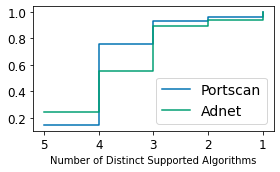

In [12]:
df_algo_support_combined_cdf_plot = df_combined_cumsum.plot.line(drawstyle='steps-post',subplots=False, sharex=True, sharey=True, fontsize=12, linewidth=1.5, figsize=(4,2.5))
df_algo_support_combined_cdf_plot.legend(loc=2, prop={'size': 23})

df_algo_support_combined_cdf_plot.invert_xaxis()

df_algo_support_combined_cdf_plot.set_xlabel("Number of Distinct Supported Algorithms")
df_algo_support_combined_cdf_plot.legend(loc=0, prop={'size': 14}, labels=["Portscan", "Adnet"])
df_algo_support_combined_cdf_plot.get_figure().tight_layout()
df_algo_support_combined_cdf_plot.get_figure().savefig(STATS_DIR + f'/resolver_algorithm_support.pdf', format='pdf')